In [1]:
#control set approximation

#import the packages from the local environment
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

  Activating project at `~/Research/cvx-mpc-solarsailing`


In [2]:
using LinearAlgebra 
using ForwardDiff
using SatelliteDynamics
using Plots

In [6]:
include("../src/parameters.jl")

ThreeBodySystem_EarthMoon (generic function with 1 method)

In [3]:
#Solar Sail Parameters
#area
A = 10 #m2
W = 1368 #solar flux at the sun earth distance (units: J/s m2)

1368

In [4]:
#arbitrary sun position

sun_position = 
[-1.3270621770866199e8,
-6.332026815757073e7,
-6.406895089769898e6]

3-element Vector{Float64}:
 -1.3270621770866199e8
 -6.332026815757073e7
 -6.406895089769898e6

In [10]:
#arbitrary satellite position
satellite_position = 
[431249.946141646,
0.0,
2286.7765081086145]

3-element Vector{Float64}:
 431249.946141646
      0.0
   2286.7765081086145

In [11]:
Earth_Moon = ThreeBodySystem_EarthMoon()

ThreeBodySystem(0.01215, 0.98785, 0.01215, 4.0, [-0.01215, 0.0, 0.0], [0.98785, 0.0, 0.0], 385000.0, 4.349129868518112, 88523.45449302066, 20354.29089708545, [0.8369180073169304, 0.0, 0.0, 0.0, 0.0, 0.0], [1.1556799130947355, 0.0, 0.0, 0.0, 0.0, 0.0])

In [12]:
#vector from the sun to the satellite. this is the direction of the maximum control authority
sun_satellite_position =  satellite_position - sun_position 

3-element Vector{Float64}:
 1.3313746765480363e8
 6.332026815757073e7
 6.409181866278007e6

In [15]:
gamma = ((2*A*W/C_LIGHT)*(norm(sun_position - Earth_Moon.pose_m1*Earth_Moon.position_scale)/norm(sun_satellite_position))^2)*(86400^2/1000)

677.6491822969106

In [14]:
Earth_Moon.pose_m1 

3-element Vector{Float64}:
 -0.01215
  0.0
  0.0

In [16]:
#assume the direction of the sun is [0,0,1] to simplify the plot
sun_dir = [0,0,1]

3-element Vector{Int64}:
 0
 0
 1

In [17]:
#non linear equation for the control set
#sample control directions

function solar_sail_control(optimal_u_norm)

    cos_angle = dot(sun_dir, optimal_u_norm)

    actual_control = gamma*(cos_angle)^2*optimal_u_norm

    return actual_control 

end

solar_sail_control (generic function with 1 method)

In [18]:
N_samples = 100

sample_angles = LinRange(0, pi, N_samples)

100-element LinRange{Float64, Int64}:
 0.0, 0.0317333, 0.0634665, 0.0951998, …, 3.04639, 3.07813, 3.10986, 3.14159

In [19]:
all_ssail_ctrl = zeros(3, N_samples)

3×100 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [20]:
for i=1:N_samples

    y = cos(sample_angles[i])
    z = sin(sample_angles[i])

    sample = [0, y, z]

    sample_norm = sample/norm(sample)

    ssail_ctrl = solar_sail_control(sample_norm)

    all_ssail_ctrl[:,i] = ssail_ctrl

end

In [21]:
#take the mean to find the centroid of the ellipse
y_center = sum(all_ssail_ctrl[2,:])/N_samples

z_center = sum(all_ssail_ctrl[3,:])/N_samples

284.72721660805377

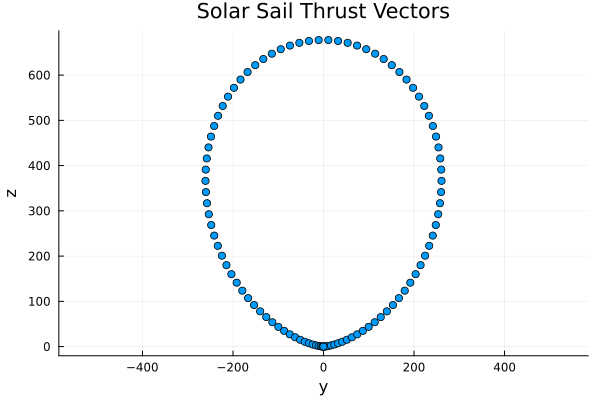

In [22]:
scatter([all_ssail_ctrl[2,:]], [all_ssail_ctrl[3,:]], aspectratio = 1, legend=false)

title!("Solar Sail Thrust Vectors")
xlabel!("y")
ylabel!("z")

In [23]:
all_predictions = zeros(N_samples)

100-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [24]:
#compute prediction 

#x is the current initial guess for the ellipsoid parameters and 
# samples is all the points in the nonlinear control set

#samples size 2xN_samples

function predictions(x, samples)

    all_predictions = zeros(eltype(x), N_samples)

    y0 = x[1]
    z0 = x[2]
    a2 = x[3]^2
    b2 = x[4]^2

    for i=1:N_samples

        y = samples[1, i]
        z = samples[2, i]

        zeta0 = (y-y0)^2 /a2
        zeta1 = (z-z0)^2 /b2

        all_predictions[i] = zeta0+zeta1

    end

    return all_predictions
end

predictions (generic function with 1 method)

In [ ]:
#intitial guess
test = [0, gamma/2, 521/2, gamma/2]

#test the residual function 
rez = predictions(test, all_ssail_ctrl[2:3, :])

100-element Vector{Float64}:
 1.0
 0.9998790974196323
 0.9990888034149584
 0.9971148616088562
 0.993611610301725
 0.9883966188752508
 0.9814405497933301
 0.9728527316382858
 0.9628630565317167
 0.9518009210898172
 ⋮
 0.9628630565317167
 0.9728527316382859
 0.9814405497933301
 0.9883966188752508
 0.993611610301725
 0.9971148616088559
 0.9990888034149584
 0.9998790974196323
 1.0

In [26]:
#this is the "algebraic distance"
function loss(x)

    loss = zeros(eltype(x),1)

    pred = zeros(eltype(x), N_samples)
    
    pred = predictions(x, all_ssail_ctrl[2:3, :])

    target = ones(N_samples)

    loss = (1/N_samples)*(sum((pred - target).^2))

    return loss

end

loss (generic function with 1 method)

In [27]:
#initial guess 
x_iter = test 

#number of iterations
N_iterations = 1000

#tolerance
tol = 1e-12

1.0e-12

In [ ]:
#save the norm of the jacobian
#when the norm is zero, we solved the problem 
all_norm_jac = zeros(N_iterations)

1000-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [ ]:
#Newton's method
for i = 1:N_iterations

    jac = ForwardDiff.gradient(dx->loss(dx), x_iter)

    hessian = ForwardDiff.hessian(dx->loss(dx), x_iter)

    Δx = -hessian\jac
    
    x_iter += Δx

    all_norm_jac[i] = norm(jac)

    #println("Norm of jacobian: ", all_norm_jac)

    if(norm(jac) < tol)

        println("solved")

        break

    end

end